# Note
This notebook is adapted from https://github.com/Slowika/Bag-of-Recipes

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sklearn

from sklearn.decomposition import PCA
import time

from sklearn.model_selection import train_test_split
from recommendation_evaluation_functions import recommend_ingredients, held_out_recommendation, calculate_metrics

%matplotlib inline

# Import data

In [10]:
X = pd.read_csv('data/recipes.csv')
cuisines_ids = X.pop('cuisine')

for column in X.columns:
  X.rename(columns={column:column.replace(' ', '_').replace("'", "")}, inplace=True)
  X.rename(columns={column:column.lower()}, inplace=True)

X.head()


acorn_squash  adobo  african_birdseye_chile_pepper  ale  aleppo_pepper  \
0             0      0                              0    0              0   
1             0      0                              0    0              0   
2             0      0                              0    0              0   
3             0      0                              0    0              0   
4             0      0                              0    0              0   

   alfalfa_sprouts  alfredo_sauce  allspice  almond  almond_butter  ...  yams  \
0                0              0         0       0              0  ...     0   
1                0              0         0       0              0  ...     0   
2                0              0         0       0              0  ...     0   
3                0              0         0       0              0  ...     0   
4                0              0         0       0              0  ...     0   

   yeast  yellow_curry_paste  yellow_food_coloring  yellow_split_pea  \
0      0                   0                     0                 0   
1      0                   0                     0                 0   
2      0                   0                     0                 0   
3      0                   0                     0                 0   
4      0                   0                     0                 0   

   yellow_squash  yogurt  zaatar  zest  zucchini  
0              0       0       0     0         0  
1              0       0       0     0         0  
2              0       0       0     0         0  
3              0       0       0     0         0  
4              0       0       0     0         0  

[5 rows x 709 columns]

In [11]:
cuisines_df = pd.read_csv("data/Cuisines.csv", header = None)
cuisines_df.columns = ["cuisine", "cuisine_name"]
cuisines_df["cuisine"] = cuisines_df["cuisine"] -1
cuisines = pd.merge(cuisines_ids, cuisines_df, how='left').drop('cuisine', axis=1)
cuisines.set_index(X.index, inplace=True)
cuisines.head()

cuisine_name
0      Chinese
1      Chinese
2      Chinese
3      Chinese
4      Chinese

# Model evaluation

## Split the data into train and test set

In [3]:
X_train, X_test = train_test_split(X, test_size=0.8, random_state=42)

## Tune alpha parameter cosine similarity

In [32]:
# Initialise dataframe of results
results_alpha_PCA = pd.DataFrame(columns = ["k", "similarity_measure", "recall10", "mean_rank", 
                                            "median_rank"])

alpha_grid = np.linspace(0.05,0.35,7)
user_item_matrix = X_train

# Fix number of neighbours to 50 and use PCA to evaluate (roughly) the optimal value of alpha
model_config = [50, "asymmetric_cosine", len(X.columns)]

for alpha in alpha_grid:   
    
    missing_ingredients, recommendations = held_out_recommendation(user_item_matrix, model_config, usePCA=True,
                                                                   alpha = alpha)  
    for k, recs in recommendations.items():
        results_alpha_PCA = results_alpha_PCA.append(calculate_metrics(missing_ingredients, recs, 
                                                                       model_config[0],  
                                                                       model_config[1]),ignore_index=True)

In [33]:
results_alpha_PCA

k similarity_measure recall10 mean_rank median_rank top10_presence
0  [50]  asymmetric_cosine      NaN    40.227           4       0.678487
1  [50]  asymmetric_cosine      NaN   37.7872           3       0.652482
2  [50]  asymmetric_cosine      NaN   31.7778           4       0.659574
3  [50]  asymmetric_cosine      NaN   25.9882           4       0.666667
4  [50]  asymmetric_cosine      NaN    24.565           3       0.683215
5  [50]  asymmetric_cosine      NaN   22.5863           3       0.685579
6  [50]  asymmetric_cosine      NaN   21.5674           3       0.683215

## Without PCA

In [6]:
start_time = time.time()
results = pd.DataFrame(columns=["k", "similarity_measure", "recall10", "mean_rank", "median_rank"])

k_grid              = [10, 20, 50, 100, 150, 200]
similarity_measures = ["cosine", "asymmetric_cosine", "jaccard", "pmi"]
n_recommendations   = len(X.columns)
user_item_matrix  = X_train

for sim in similarity_measures:
    
    model_config = [k_grid, sim, n_recommendations]
    missing_ingredients, recommendations = held_out_recommendation(user_item_matrix, model_config)
    
    for k, recs in recommendations.items():
        results = results.append(calculate_metrics(missing_ingredients, recs, k, sim), 
                                 ignore_index = True)    

print("--- %s minutes ---" % (round( (time.time() - start_time)/60, 3)))
results.to_csv('results/parameter_settings_train.csv', sep = '\t')

stead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pmi.values[[range(pmi.shape[0])]*2] = 0 # Set self-PMI to zero.
x:\DME\Bag-of-Recipes-master\similarity_functions.py:68: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pmi.values[[range(pmi.shape[0])]*2] = 0 # Set self-PMI to zero.
x:\DME\Bag-of-Recipes-master\similarity_functions.py:68: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pmi.values[[range(pmi.shape[0])]*2] = 0 # Set s

In [7]:
results

k similarity_measure  recall10   mean_rank  median_rank
0    10             cosine  0.330579   78.252656           23
1    20             cosine  0.311688   72.293979           22
2    50             cosine  0.107438   73.775679           36
3   100             cosine  0.025974   91.374262           59
4   150             cosine  0.024793  105.722550           81
5   200             cosine  0.024793  115.731995           96
6    10  asymmetric_cosine  0.000000  410.035419          404
7    20  asymmetric_cosine  0.000000  410.035419          404
8    50  asymmetric_cosine  0.000000  410.035419          404
9   100  asymmetric_cosine  0.000000  410.035419          404
10  150  asymmetric_cosine  0.000000  410.035419          404
11  200  asymmetric_cosine  0.000000  410.035419          404
12   10            jaccard  0.345927   81.327037           18
13   20            jaccard  0.363636   62.760331           16
14   50            jaccard  0.311688   53.839433           17
15  100            jaccard  0.257379   54.080283           20
16  150            jaccard  0.229044   55.453365           22
17  200            jaccard  0.204250   56.610390           24
18   10                pmi  0.000000  410.035419          404
19   20                pmi  0.000000  410.035419          404
20   50                pmi  0.000000  410.035419          404
21  100                pmi  0.000000  410.035419          404
22  150                pmi  0.000000  410.035419          404
23  200                pmi  0.000000  410.035419          404

## Same settings, with PCA

In [14]:
start_time = time.time()
results_PCA = pd.DataFrame(columns = ["k", "similarity_measure", "recall10", "mean_rank", "median_rank"])

k_grid              = [10, 20, 50, 100, 150, 200]
similarity_measures = ["cosine", "asymmetric_cosine", "jaccard", "pmi"]
n_recommendations   = len(X.columns)
user_item_matrix  = X_train

for sim in similarity_measures:
    
    model_config = [k_grid, sim, n_recommendations]
    missing_ingredients, recommendations = held_out_recommendation(user_item_matrix, model_config, usePCA = True)
    
    for k, recs in recommendations.items():
        results_PCA = results_PCA.append(calculate_metrics(missing_ingredients, recs, k, sim), 
                            ignore_index = True)
        
print("--- %s minutes ---" % (round( (time.time() - start_time)/60, 3)))
results_PCA.to_csv('results/parameter_settings_train_PCA.csv', sep='\t')


instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pmi.values[[range(pmi.shape[0])]*2] = 0 # Set self-PMI to zero.
x:\DME\Bag-of-Recipes-master\similarity_functions.py:68: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pmi.values[[range(pmi.shape[0])]*2] = 0 # Set self-PMI to zero.
x:\DME\Bag-of-Recipes-master\similarity_functions.py:68: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pmi.values[[range(pmi.shape[0])]*2] = 0 # Set

In [214]:
results_PCA

k similarity_measure  top10_presence  mean_rank  median_rank
0    10             cosine        0.380557  54.132566         18.0
1    20             cosine        0.408945  41.655329         15.0
2    50             cosine        0.432780  33.290305         13.0
3   100             cosine        0.427424  32.005624         13.0
4   150             cosine        0.419122  34.908141         14.0
5   200             cosine        0.411623  38.991698         15.0
6    10  asymmetric_cosine        0.386181  59.019550         18.0
7    20  asymmetric_cosine        0.421800  44.261650         14.0
8    50  asymmetric_cosine        0.441885  33.510177         13.0
9   100  asymmetric_cosine        0.441618  31.544992         12.0
10  150  asymmetric_cosine        0.432780  35.292448         13.0
11  200  asymmetric_cosine        0.414569  43.150777         15.0
12   10            jaccard        0.382967  53.737279         18.0
13   20            jaccard        0.409213  41.633905         15.0
14   50            jaccard        0.429834  33.652651         13.0
15  100            jaccard        0.430637  32.277183         13.0
16  150            jaccard        0.431976  33.651312         13.0
17  200            jaccard        0.432244  35.747188         13.0
18   10                pmi        0.382432  65.761114         20.0
19   20                pmi        0.418050  47.915640         14.5
20   50                pmi        0.445903  35.097750         12.0
21  100                pmi        0.443492  31.521425         12.0
22  150                pmi        0.433851  36.751473         13.0
23  200                pmi        0.407606  47.735672         15.0

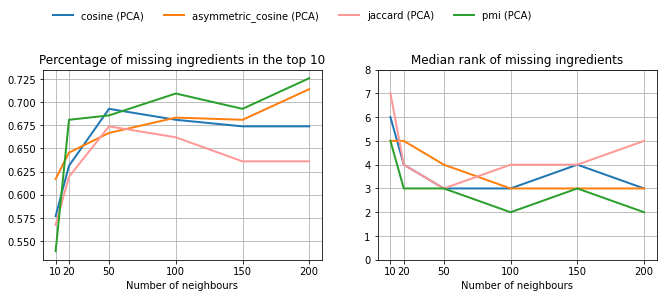

In [13]:
top10_pca       = results_PCA['recall10']
# top10           = results    ['top10_presence']
median_pca      = results_PCA['median_rank']
# median          = results    ['median_rank']

color_sequence = ['#1f77b4', '#ff7f0e', '#ff9896', '#2ca02c']

fig, ax = plt.subplots(1, 2, sharex=True, figsize=(11, 3.5))

for sim, color in zip(similarity_measures, color_sequence):
    ax[0].plot(k_grid, top10_pca.loc[results_PCA['similarity_measure'] == sim], color, 
             linewidth = 2, label = sim + ' (PCA)')
    # ax[0].plot(k_grid, top10.loc[results['similarity_measure'] == sim], color, linewidth = 2, 
    #          linestyle = "--", label = sim)
    ax[1].plot(k_grid, median_pca.loc[results_PCA['similarity_measure'] == sim], color, 
               linewidth = 2, label = sim + ' (PCA)')
    # ax[1].plot(k_grid, median.loc[results['similarity_measure'] == sim], color, linewidth = 2, 
    #          linestyle = "--", label = sim)

ax[1].set_ylim((0,8))

for i in [0,1]:
    ax[i].grid(); 
    ax[i].set_xlabel('Number of neighbours')


ax[0].set_title("Percentage of missing ingredients in the top 10")
ax[1].set_title("Median rank of missing ingredients")

ax[1].set_xticks(k_grid)

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', frameon=False, ncol=4, bbox_to_anchor = (0.44,1.15))

plt.show()
fig.savefig('plots/k_tuning.pdf', bbox_inches="tight")

## Run all similarity metrics with best k and PCA (50)

In [14]:
results_model_sel = pd.DataFrame(columns = ["k", "similarity_measure", "recall10", 
                                            "mean_rank", "median_rank"])
k_grid              = [100] # was 50
similarity_measures = ["cosine", "asymmetric_cosine", "jaccard", "pmi"]
n_recommendations   = len(X.columns)
user_item_matrix    = X_test

for sim in similarity_measures:
    
    model_config = [k_grid, sim, n_recommendations]
    missing_ingredients, recommendations = held_out_recommendation(user_item_matrix, model_config, usePCA = True)
    
    for k, recs in recommendations.items():
        results_model_sel = results_model_sel.append(calculate_metrics(missing_ingredients, recs, k, sim), 
                            ignore_index = True)

se `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pmi.values[[range(pmi.shape[0])]*2] = 0 # Set self-PMI to zero.
x:\DME\Bag-of-Recipes-master\similarity_functions.py:68: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pmi.values[[range(pmi.shape[0])]*2] = 0 # Set self-PMI to zero.
x:\DME\Bag-of-Recipes-master\similarity_functions.py:68: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pmi.values[[range(pmi.sh

In [5]:
results_model_sel # with k =200

k similarity_measure  recall10 mean_rank median_rank
0  200             cosine  0.492476   37.8595          10
1  200  asymmetric_cosine  0.523458   44.7244           9
2  200            jaccard  0.519327   36.1711           9
3  200                pmi  0.534081   48.7722           8

## Sample predictions from our best model

In [19]:
n       = X.shape[1] # surely 1??
pca     = PCA(n_components = n) # changed to 2 from n to make this work
X_pca_T = pca.fit_transform(X.T)
X_pca   = pd.DataFrame(X_pca_T.T, columns = X.columns)

In [20]:
recommendations = recommend_ingredients(X, X_pca, similarity_measure = "pmi", k = 200) # TODO k was 50 before

x:\DME\Bag-of-Recipes-master\similarity_functions.py:68: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pmi.values[[range(pmi.shape[0])]*2] = 0 # Set self-PMI to zero.


In [ ]:
recipe1 = 3
recipe2 = 500

print('Recipe {} ({}): \n{}\n'.format(X.index[recipe1], 
                                      cuisines.iloc[recipe1, 0],
                                      X.columns[np.where(X.iloc[recipe1,] != 0)]))
print('Recommended ingredients: \n{}\n\n'.format(recommendations[100][recipe1,]))

print('Recipe {} ({}): \n{}\n'.format(X.index[recipe2], 
                                      cuisines.iloc[recipe2, 0],
                                      X.columns[np.where(X.iloc[recipe2,] != 0)]))
print('Recommended ingredients: \n{}\n\n'.format(recommendations[100][recipe2,]))